# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Курсовой проект

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты.

На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.

Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.

In [1]:
# !pip install opencv-python
# !pip install facenet_pytorch

In [2]:
import os
import shutil
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from torch.autograd import Variable
from PIL import Image
from pylab import *
import cv2
from facenet_pytorch import MTCNN

%matplotlib inline

In [3]:
data_dir = 'images/gestures'

Перенес файлов папку test

In [4]:
# trainfiles = []
# for root, dirs, files in os.walk(data_dir, topdown = False):
#     for file in files:
#         trainfiles.append(os.path.join(root, file).replace('\\', '/'))

In [5]:
# len(trainfiles)

In [6]:
# testfiles = np.random.choice(trainfiles, size=500, replace=False)

In [7]:
# len(testfiles)

In [8]:
# for full_filename in testfiles:
#     filename = full_filename.split('/')[-1]
#     shutil.move(full_filename, f'images/gestures/test/{filename}')

Предварительная подготовка изображения

In [9]:
# for root, dirs, files in os.walk(data_dir, topdown = False):
#     for file in files:
#         im = Image.open(os.path.join(root, file).replace('\\', '/'))
#         im = im.resize((64, 64))
# #         im = im.crop((22, 0, 150, 128))
# #         im = im.resize((48, 48))
#         im.save(os.path.join(root, file).replace('\\', '/'))

Воспроизводим все шаги с 5-го урока для обучения модели на другом дата сете

__Подготовка данных__

In [10]:
train_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

test_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [11]:
print(os.listdir(data_dir))

['test', 'train']


In [12]:
classes_train = os.listdir(data_dir + "/train")
classes_test = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

Train Classes - ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']
test Classes - ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


In [13]:
digit_to_classname = {0:'01_palm', 
                      1:'02_l', 
                      2:'03_fist', 
                      3:'04_fist_moved', 
                      4:'05_thumb', 
                      5:'06_index', 
                      6:'07_ok', 
                      7:'08_palm_moved', 
                      8:'09_c', 
                      9:'10_down'}

In [14]:
train_dataset = ImageFolder(data_dir + '/train', train_transforms)
test_dataset  = ImageFolder(data_dir + '/test', test_transforms)

In [15]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 1500
    Root location: images/gestures/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               ToTensor()
           )

In [16]:
batch_size = 100

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

In [18]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 64, 64])


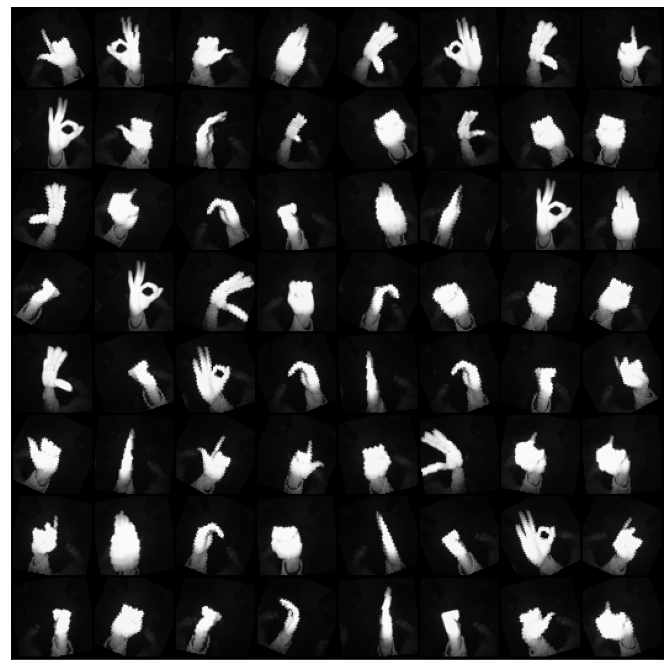

In [19]:
show_batch(train_dataloader)

In [20]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

__Создание модели__

In [5]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [24]:
model = to_device(ResNet(1, len(classes_train)), device)

__Обучение__

In [25]:
# Если работаете на гпу, очищаем весь кэш
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()


epochs = 50
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)

In [26]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

50 epochs, 15 total_steps per epoch


In [27]:
print(torch.__version__)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

1.6.0


In [28]:
epoch_losses = []
for epoch in range(epochs):
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = Variable(data), Variable(labels)
        data = data.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 1, loss:  3.739107950528463
Epoch 2, loss:  0.8065094451109568
Epoch 3, loss:  0.3757958839337031
Epoch 4, loss:  0.22671613693237305
Epoch 5, loss:  0.14587198918064434
Epoch 6, loss:  0.13498149638374646
Epoch 7, loss:  0.0912060504158338
Epoch 8, loss:  0.08017280741284291
Epoch 9, loss:  3.016949001948039
Epoch 10, loss:  0.7805828213691711
Epoch 11, loss:  0.21589352091153463
Epoch 12, loss:  0.10105262100696563
Epoch 13, loss:  0.06627900308618943
Epoch 14, loss:  0.04977816008031368
Epoch 15, loss:  0.06186356496376296
Epoch 16, loss:  0.04979265906537573
Epoch 17, loss:  0.0339421725521485
Epoch 18, loss:  0.01571817065899571
Epoch 19, loss:  0.020782426201427975
Epoch 20, loss:  0.014183577173389495
Epoch 21, loss:  0.015983465950315197
Epoch 22, loss:  0.010904173149416845
Epoch 23, loss:  0.005511997601327797
Epoch 24, loss:  0.012473894190043211
Epoch 25, loss:  0.011052840540651232
Epoch 26, loss:  0.011086594608301917
Epoch 27, loss:  0.004906175033344577
Epoch 28, 

Text(0.5, 1.0, 'losses vs. No. of epochs')

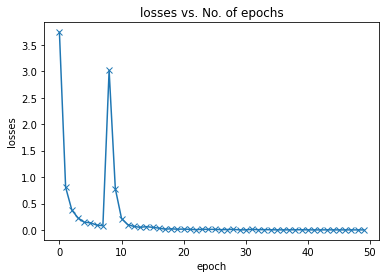

In [29]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [30]:
torch.save(model.state_dict(), 'models/gestures_detection_model_state_50_epoch.pth')

__Результаты__

In [31]:
net=ResNet(1, len(classes_train)).to(device)
net.load_state_dict(torch.load('models/gestures_detection_model_state_50_epoch.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


tensor([[[[0.0196, 0.0196, 0.0196,  ..., 0.0118, 0.0118, 0.0118],
          [0.0196, 0.0196, 0.0196,  ..., 0.0118, 0.0118, 0.0118],
          [0.0196, 0.0196, 0.0196,  ..., 0.0118, 0.0118, 0.0118],
          ...,
          [0.0157, 0.0157, 0.0157,  ..., 0.0353, 0.0314, 0.0275],
          [0.0196, 0.0157, 0.0157,  ..., 0.0314, 0.0314, 0.0275],
          [0.0196, 0.0157, 0.0157,  ..., 0.0275, 0.0275, 0.0275]]],


        [[[0.0196, 0.0196, 0.0196,  ..., 0.0157, 0.0157, 0.0157],
          [0.0196, 0.0196, 0.0235,  ..., 0.0157, 0.0157, 0.0157],
          [0.0196, 0.0196, 0.0235,  ..., 0.0157, 0.0157, 0.0118],
          ...,
          [0.0157, 0.0157, 0.0157,  ..., 0.0431, 0.0392, 0.0353],
          [0.0157, 0.0157, 0.0157,  ..., 0.0431, 0.0392, 0.0353],
          [0.0196, 0.0157, 0.0157,  ..., 0.0392, 0.0392, 0.0353]]],


        [[[0.0235, 0.0235, 0.0235,  ..., 0.0196, 0.0196, 0.0196],
          [0.0235, 0.0235, 0.0235,  ..., 0.0196, 0.0196, 0.0157],
          [0.0235, 0.0235, 0.0235,  ..

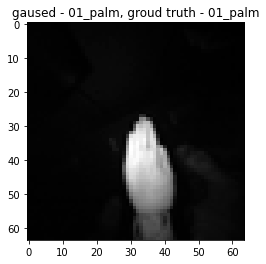

tensor([[[[0.0235, 0.0275, 0.0275,  ..., 0.0275, 0.0235, 0.0235],
          [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0235, 0.0235],
          [0.0275, 0.0275, 0.0275,  ..., 0.0235, 0.0235, 0.0275],
          ...,
          [0.0235, 0.0196, 0.0196,  ..., 0.0588, 0.0510, 0.0471],
          [0.0235, 0.0235, 0.0196,  ..., 0.0549, 0.0510, 0.0471],
          [0.0235, 0.0196, 0.0196,  ..., 0.0471, 0.0431, 0.0431]]],


        [[[0.0392, 0.0392, 0.0353,  ..., 0.0196, 0.0196, 0.0196],
          [0.0392, 0.0392, 0.0353,  ..., 0.0196, 0.0196, 0.0196],
          [0.0431, 0.0431, 0.0392,  ..., 0.0196, 0.0196, 0.0196],
          ...,
          [0.0275, 0.0275, 0.0275,  ..., 0.0431, 0.0392, 0.0392],
          [0.0275, 0.0275, 0.0275,  ..., 0.0392, 0.0392, 0.0353],
          [0.0275, 0.0314, 0.0275,  ..., 0.0392, 0.0392, 0.0392]]],


        [[[0.0431, 0.0431, 0.0392,  ..., 0.0235, 0.0196, 0.0196],
          [0.0431, 0.0431, 0.0392,  ..., 0.0235, 0.0196, 0.0196],
          [0.0392, 0.0392, 0.0392,  ..

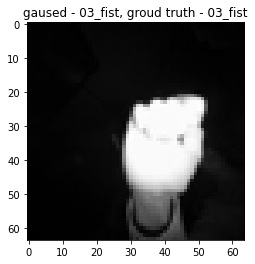

tensor([[[[0.0275, 0.0235, 0.0275,  ..., 0.0235, 0.0235, 0.0235],
          [0.0235, 0.0235, 0.0275,  ..., 0.0235, 0.0235, 0.0235],
          [0.0235, 0.0235, 0.0275,  ..., 0.0235, 0.0235, 0.0235],
          ...,
          [0.0235, 0.0196, 0.0235,  ..., 0.0549, 0.0510, 0.0471],
          [0.0235, 0.0235, 0.0235,  ..., 0.0471, 0.0471, 0.0431],
          [0.0196, 0.0196, 0.0235,  ..., 0.0431, 0.0431, 0.0392]]],


        [[[0.0353, 0.0353, 0.0353,  ..., 0.0196, 0.0196, 0.0196],
          [0.0353, 0.0353, 0.0353,  ..., 0.0157, 0.0196, 0.0196],
          [0.0353, 0.0353, 0.0353,  ..., 0.0157, 0.0157, 0.0196],
          ...,
          [0.0275, 0.0275, 0.0275,  ..., 0.0392, 0.0392, 0.0353],
          [0.0235, 0.0235, 0.0275,  ..., 0.0392, 0.0353, 0.0353],
          [0.0235, 0.0275, 0.0235,  ..., 0.0353, 0.0353, 0.0353]]],


        [[[0.0353, 0.0353, 0.0353,  ..., 0.0196, 0.0157, 0.0157],
          [0.0353, 0.0353, 0.0314,  ..., 0.0196, 0.0196, 0.0157],
          [0.0353, 0.0353, 0.0314,  ..

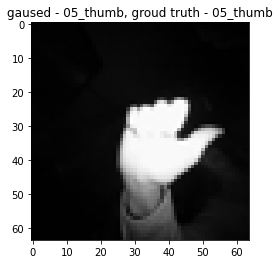

tensor([[[[0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          [0.0275, 0.0275, 0.0235,  ..., 0.0275, 0.0275, 0.0275],
          [0.0314, 0.0314, 0.0275,  ..., 0.0275, 0.0275, 0.0275],
          ...,
          [0.0235, 0.0235, 0.0235,  ..., 0.0588, 0.0549, 0.0510],
          [0.0235, 0.0235, 0.0235,  ..., 0.0510, 0.0510, 0.0471],
          [0.0235, 0.0235, 0.0235,  ..., 0.0471, 0.0471, 0.0471]]],


        [[[0.0275, 0.0275, 0.0275,  ..., 0.0235, 0.0196, 0.0235],
          [0.0275, 0.0275, 0.0275,  ..., 0.0235, 0.0235, 0.0235],
          [0.0275, 0.0275, 0.0275,  ..., 0.0235, 0.0235, 0.0235],
          ...,
          [0.0235, 0.0235, 0.0196,  ..., 0.0549, 0.0510, 0.0471],
          [0.0196, 0.0196, 0.0235,  ..., 0.0510, 0.0510, 0.0431],
          [0.0235, 0.0235, 0.0235,  ..., 0.0471, 0.0431, 0.0431]]],


        [[[0.0392, 0.0392, 0.0353,  ..., 0.0196, 0.0196, 0.0196],
          [0.0392, 0.0392, 0.0392,  ..., 0.0196, 0.0196, 0.0196],
          [0.0392, 0.0392, 0.0392,  ..

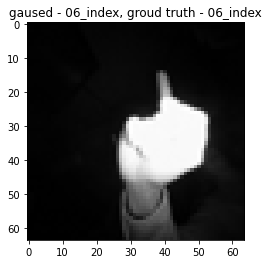

tensor([[[[0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0196],
          [0.0235, 0.0235, 0.0235,  ..., 0.0196, 0.0196, 0.0196],
          [0.0235, 0.0235, 0.0235,  ..., 0.0196, 0.0235, 0.0235],
          ...,
          [0.0196, 0.0196, 0.0196,  ..., 0.0510, 0.0471, 0.0431],
          [0.0196, 0.0196, 0.0196,  ..., 0.0471, 0.0471, 0.0431],
          [0.0196, 0.0196, 0.0196,  ..., 0.0431, 0.0392, 0.0392]]],


        [[[0.0314, 0.0314, 0.0275,  ..., 0.0157, 0.0157, 0.0157],
          [0.0314, 0.0314, 0.0314,  ..., 0.0157, 0.0157, 0.0157],
          [0.0314, 0.0314, 0.0314,  ..., 0.0157, 0.0196, 0.0196],
          ...,
          [0.0275, 0.0275, 0.0275,  ..., 0.0392, 0.0392, 0.0392],
          [0.0235, 0.0235, 0.0235,  ..., 0.0353, 0.0353, 0.0353],
          [0.0235, 0.0275, 0.0235,  ..., 0.0353, 0.0353, 0.0353]]],


        [[[0.0235, 0.0235, 0.0235,  ..., 0.0196, 0.0196, 0.0196],
          [0.0235, 0.0235, 0.0196,  ..., 0.0235, 0.0196, 0.0196],
          [0.0235, 0.0235, 0.0196,  ..

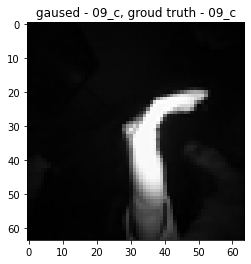

In [53]:
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, labels = data
        images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)
        print(images)
        print(type(images))
        outputs = net(images)
        plt.title(f'gaused - {digit_to_classname[int(outputs[0].argmax())]}, groud truth - {digit_to_classname[int(labels[0])]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

__Приложение__

In [22]:
# Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
cap = cv2.VideoCapture(0)  

# Класс детектирования и обработки лица с веб-камеры 
class FaceDetector(object):

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = ResNet(1, 10).to(self.device)
        self.emodel.load_state_dict(torch.load('models/gestures_detection_model_state_50_epoch.pth'))
        self.emodel.eval()

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs, landmarks):
#     def _draw(self, frame, boxes, probs, landmarks, gesture):
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # пишем на кадре какая эмоция распознана
#                 cv2.putText(frame, 
#                     gesture, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Рисуем особенные точки
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            print('Something wrong im draw function!')
#             pass

        return frame
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
        
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return '01_palm'
        elif digit == 1:
            return '02_l'
        elif digit == 2:
            return '03_fist'
        elif digit == 3:
            return '04_fist_moved'
        elif digit == 4:
            return '05_thumb'
        elif digit == 5:
            return '06_index'
        elif digit == 6:
            return '07_ok'
        elif digit == 7:
            return '08_palm_moved'
        elif digit == 8:
            return '09_c'
        elif digit == 9:
            return '10_down'
        
    def detecte(self, frame):
        d = 16.0
        height, width = frame.shape[0], frame.shape[1]
        h, w = int((height - 129) / d), int((width - 129) / d)
#         [[456.3015  220.84375 598.1633  390.59518]]
        for i in range(h):
            for j in range(w):
                box = [[j * d, i * d, j * d + 128.0, i * d + 128.0]]
                palm = self.crop_faces(frame, box)[0]
                palm = cv2.resize(palm,(48,48))
                palm = cv2.cvtColor(palm, cv2.COLOR_BGR2GRAY)
                torch_palm = torch.from_numpy(palm).unsqueeze(0).to(self.device).float()
                gesture = self.emodel(torch_palm[None, ...])
                gesture = self.digit_to_classname(gesture.argmax())
                if gesture != '07_ok':
                    print(self.digit_to_classname(gesture.argmax()))
                
#                 print(type(torch_palm))
#                 print(torch_palm)
#                 outputs = net(torch_palm)

#                 gesture = self.emodel(torch_palm)
#                 gesture = self.digit_to_classname(gesture.argmax())
#                 print(box)

#         print(frame.shape)
#         (480, 640, 3)
        
       
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = cap.read()
            try:
                # детектируем расположение лица на кадре, вероятности на сколько это лицо
                # и особенные точки лица
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
                
                # Вырезаем лицо из кадра
                face = self.crop_faces(frame, boxes)[0]
                # Меняем размер изображения лица для входа в нейронную сеть
                face = cv2.resize(face,(48,48))
                # Превращаем в 1-канальное серое изображение
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
                torch_face = torch.from_numpy(face).unsqueeze(0).to(self.device).float()
                
#                 print(type(torch_face))
#                 print(torch_face)
                
                self.detecte(frame)
#                 print(boxes)

#                 # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
#                 gesture = self.emodel(torch_face[None, ...])
#                 # Интерпретируем предсказание как строку нашей эмоции
#                 gesture = self.digit_to_classname(gesture.argmax())

                # Рисуем на кадре
                self._draw(frame, boxes, probs, landmarks)
#                 self._draw(frame, boxes, probs, landmarks, gesture)

            except:
                print('Something wrong im main cycle!')
#                 pass

            # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
            cv2.imshow('Face Detection', frame)
            
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        cap.release()
        cv2.destroyAllWindows()
        
        
# Загружаем мтцнн
mtcnn = MTCNN()
# Создаем объект нашего класса приложения
fcd = FaceDetector(mtcnn)
# Запускаем
fcd.run()